In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import  Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# Data Input

Link to dataset: https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction . This was downloaded and loaded onto here.

In [20]:
# Load the dataset, which was downloaded from the link
df = pd.read_csv("historical_data.csv")

In [21]:
# Inspect data to verify proper importing
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


# Data Processing

I found out the target (how long it takes to deliver) was not explicitly in the data. Here I will prepare it by subtracting actual delivery_time from created_at.

In [24]:
# Convert timestamp columns
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# This is the duration in seconds.
df['delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

I extracted the day of week as well as the hour and minutes (decimal value) from created_at, then removed it along with actual_delivery_time

In [26]:
# Extracted date parts from created_at. 
# These include day of week (in number form) as well as the time in hours
df['created_dayofweek'] = df['created_at'].dt.dayofweek   # 0 = Monday, 6 = Sunday
df['created_hour_decimal'] = df['created_at'].dt.hour + df['created_at'].dt.minute / 60

# Deleting the data used in making dates, they won't be used in practice
df= df.drop(columns = ['created_at', 'actual_delivery_time'])

# Inspecting new data
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,created_dayofweek,created_hour_decimal
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,4,22.400000
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1,21.816667
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,3,20.650000
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1,21.350000
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,6,2.666667


## Handling Missing Values

In [28]:
# Checking if there are any missing values
df.isnull().sum()

market_id                                         987
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_duration_seconds                           7
created_dayofweek                                   0
created_hour_decimal                                0
dtype: int64

Approach (3-step):
1. Drop NA values from every attribute except market_id and store_primary_category
2. Fill the remaining 2 attributes using the most common value for that specific store_id
3. Edge case where a store_id has NA for all values: drop all values

In [30]:
# Step 1. Drop NA values from every attribute except market_id and store_primary_category
df = df.dropna(subset = [ 'order_protocol',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_store_to_consumer_driving_duration',
    'delivery_duration_seconds']
)
df.shape

(179760, 17)

In [31]:
df.isnull().sum()

market_id                                        465
store_id                                           0
store_primary_category                          3744
order_protocol                                     0
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                              0
total_busy_dashers                                 0
total_outstanding_orders                           0
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration       0
delivery_duration_seconds                          0
created_dayofweek                                  0
created_hour_decimal                               0
dtype: int64

In [32]:
# Step 2. Filling in the remaining values from store_id 

# Example:
df[df['store_id'] == 4380].head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,created_dayofweek,created_hour_decimal
14032,5.0,4380,mexican,3.0,1,1125,1,970,970,16.0,8.0,12.0,251,289.0,1744.0,1,4.250000
14907,5.0,4380,mexican,3.0,5,3985,5,235,1705,25.0,25.0,40.0,251,630.0,4431.0,0,2.883333
14908,5.0,4380,mexican,3.0,4,5100,4,655,1390,26.0,17.0,31.0,251,644.0,2948.0,0,3.133333
14909,5.0,4380,mexican,3.0,1,1150,1,1150,1150,10.0,3.0,3.0,251,572.0,1791.0,6,23.350000
14910,5.0,4380,mexican,3.0,3,2020,3,160,1075,24.0,16.0,22.0,251,151.0,2955.0,0,3.533333
14911,NaN,4380,NaN,3.0,2,2435,2,1045,1390,23.0,6.0,10.0,251,627.0,3400.0,4,1.750000
14912,5.0,4380,mexican,3.0,1,970,1,970,970,27.0,25.0,45.0,251,586.0,2518.0,5,3.300000
14913,5.0,4380,mexican,3.0,1,1045,1,1045,1045,30.0,29.0,41.0,251,634.0,3404.0,5,3.650000
14914,5.0,4380,mexican,3.0,3,4010,3,1075,1390,22.0,18.0,27.0,251,296.0,3143.0,0,2.016667
14915,5.0,4380,mexican,3.0,2,3095,2,1285,1420,16.0,16.0,25.0,251,571.0,3241.0,6,4.666667


In [ ]:
# Function to get the most common value (mode)
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Fill NaNs in market_id
df['market_id'] = df.groupby('store_id')['market_id'].transform(
    lambda x: x.fillna(get_mode(x))
)

# Fill NaNs in store_primary_category
df['store_primary_category'] = df.groupby('store_id')['store_primary_category'].transform(
    lambda x: x.fillna(get_mode(x))
)


In [34]:
# Same table before, but with the values filled in
df[df['store_id'] == 4380].head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,created_dayofweek,created_hour_decimal
14032,5.0,4380,mexican,3.0,1,1125,1,970,970,16.0,8.0,12.0,251,289.0,1744.0,1,4.250000
14907,5.0,4380,mexican,3.0,5,3985,5,235,1705,25.0,25.0,40.0,251,630.0,4431.0,0,2.883333
14908,5.0,4380,mexican,3.0,4,5100,4,655,1390,26.0,17.0,31.0,251,644.0,2948.0,0,3.133333
14909,5.0,4380,mexican,3.0,1,1150,1,1150,1150,10.0,3.0,3.0,251,572.0,1791.0,6,23.350000
14910,5.0,4380,mexican,3.0,3,2020,3,160,1075,24.0,16.0,22.0,251,151.0,2955.0,0,3.533333
14911,5.0,4380,mexican,3.0,2,2435,2,1045,1390,23.0,6.0,10.0,251,627.0,3400.0,4,1.750000
14912,5.0,4380,mexican,3.0,1,970,1,970,970,27.0,25.0,45.0,251,586.0,2518.0,5,3.300000
14913,5.0,4380,mexican,3.0,1,1045,1,1045,1045,30.0,29.0,41.0,251,634.0,3404.0,5,3.650000
14914,5.0,4380,mexican,3.0,3,4010,3,1075,1390,22.0,18.0,27.0,251,296.0,3143.0,0,2.016667
14915,5.0,4380,mexican,3.0,2,3095,2,1285,1420,16.0,16.0,25.0,251,571.0,3241.0,6,4.666667


In [35]:
# Checking for remaining missing values
df.isnull().sum()

market_id                                         0
store_id                                          0
store_primary_category                          761
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration      0
delivery_duration_seconds                         0
created_dayofweek                                 0
created_hour_decimal                              0
dtype: int64

In [36]:
# Step 3. Dropping remaining edge cases
# Some restaurants may have no data on market_id and store_primary_category at all.
# We'll just remove these
df = df.dropna()

In [37]:
df.shape

(178999, 17)

## Outliers

We will observe graphs for any outliers

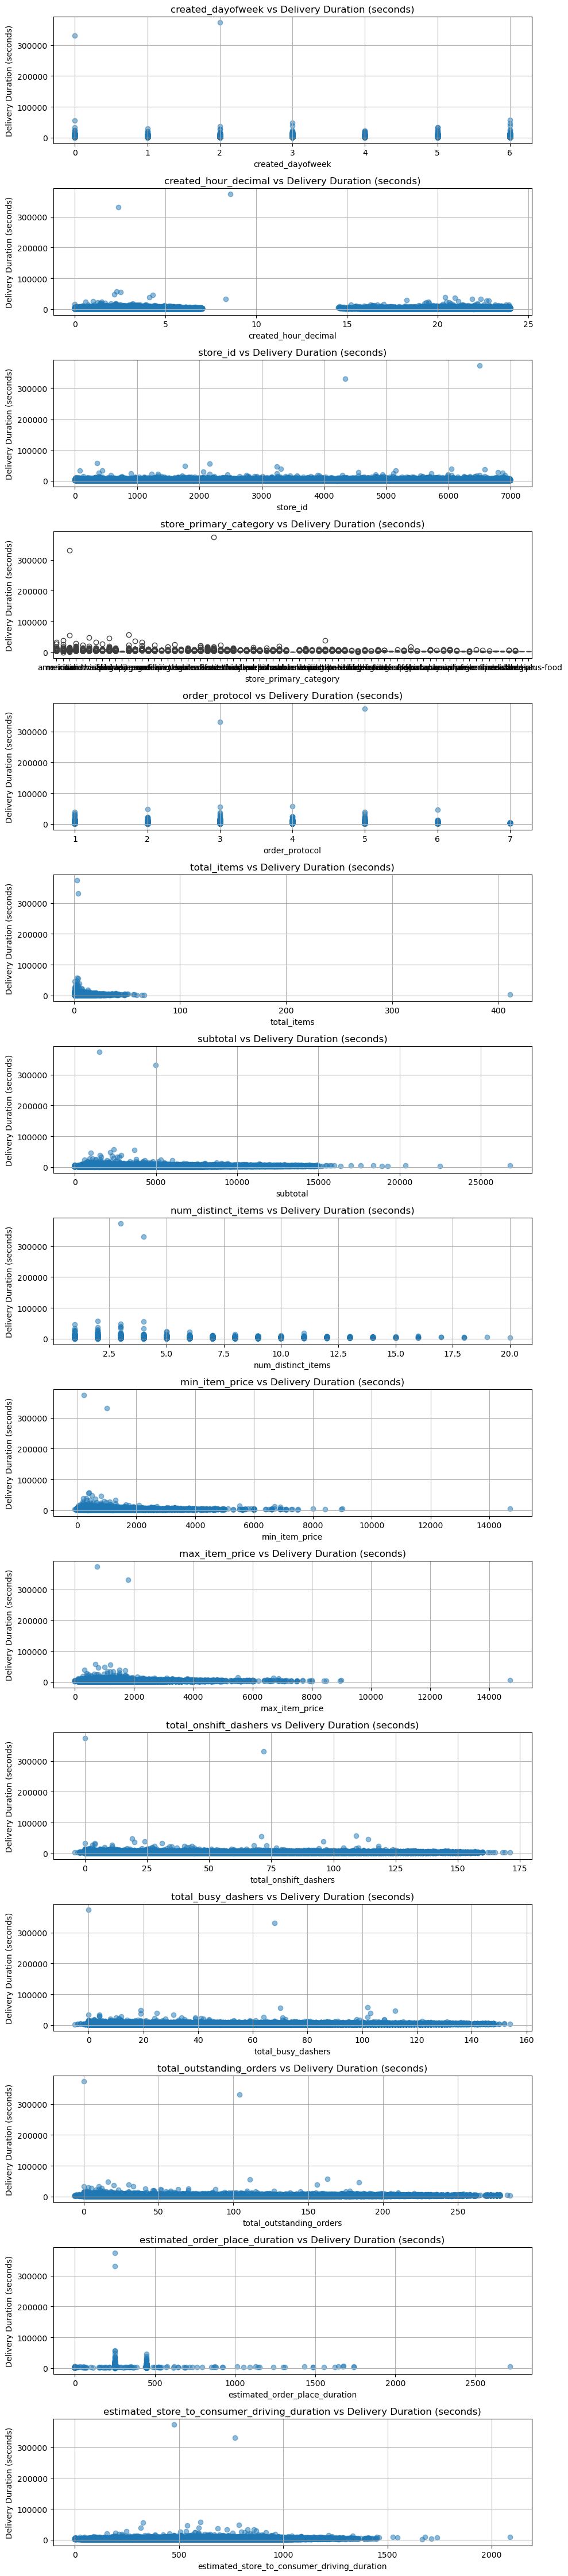

In [40]:
# Plots of all features (except actual delivery time) vs actual delivery time

# List of all features currently
features = [
    'created_dayofweek','created_hour_decimal', 'store_id', 'store_primary_category', 
    'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 
    'min_item_price', 'max_item_price', 'total_onshift_dashers', 
    'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 
    'estimated_store_to_consumer_driving_duration'
]

# Figure w/ subplots
fig, axes = plt.subplots(len(features), 1, figsize=(10, 3 * len(features)))

# Loop through each feature to plot
for i, feature in enumerate(features):
    ax = axes[i]  # get the axis for the current subplot
    
    if feature in ['created_at', 'actual_delivery_time']:  # Date columns
        df[feature] = pd.to_datetime(df[feature])
        ax.plot(df[feature], df['delivery_duration_seconds'], '.', alpha=0.3)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        ax.grid(True)
        
    elif feature == 'store_primary_category':  # Categorical columns
        sns.boxplot(x=df[feature], y=df['delivery_duration_seconds'], ax=ax)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        
    else:  # Numerical columns
        ax.scatter(df[feature], df['delivery_duration_seconds'], alpha=0.5)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Some outliers to note here are the delivery durations that are over 300,000 seconds, or 3.5 days, and an order with 400+ total items

We handle outliers by removing the top 0.05% percentile 

In [42]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Loop through each numeric column and filters high outliers
for col in numeric_cols:
    upper_bound = df[col].quantile(0.9995)
    df = df[df[col] <= upper_bound]
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,created_dayofweek,created_hour_decimal
count,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000,178016.000000
mean,2.748253,3543.887662,2.899818,3.177849,2682.820690,2.667131,682.550467,1155.513044,44.795030,41.725553,58.017689,308.475058,545.671125,2851.156930,3.221480,8.969636
std,1.331959,2056.835885,1.514894,2.339868,1791.895482,1.596807,505.321774,536.629941,34.418156,32.024140,52.468002,89.222682,217.798183,1085.799935,2.043801,8.684609
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1410.000000,2.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,384.000000,2103.000000,1.000000,2.200000
50%,2.000000,3614.000000,3.000000,3.000000,2220.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2659.000000,3.000000,3.700000
75%,4.000000,5323.000000,4.000000,4.000000,3400.000000,3.000000,942.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,703.000000,3377.000000,5.000000,19.683333
max,6.000000,6981.000000,6.000000,29.000000,13927.000000,12.000000,4669.000000,5295.000000,156.000000,145.000000,272.000000,446.000000,1272.000000,11907.000000,6.000000,23.983333


This is just the same code as last time to verify there is no more huge outliers

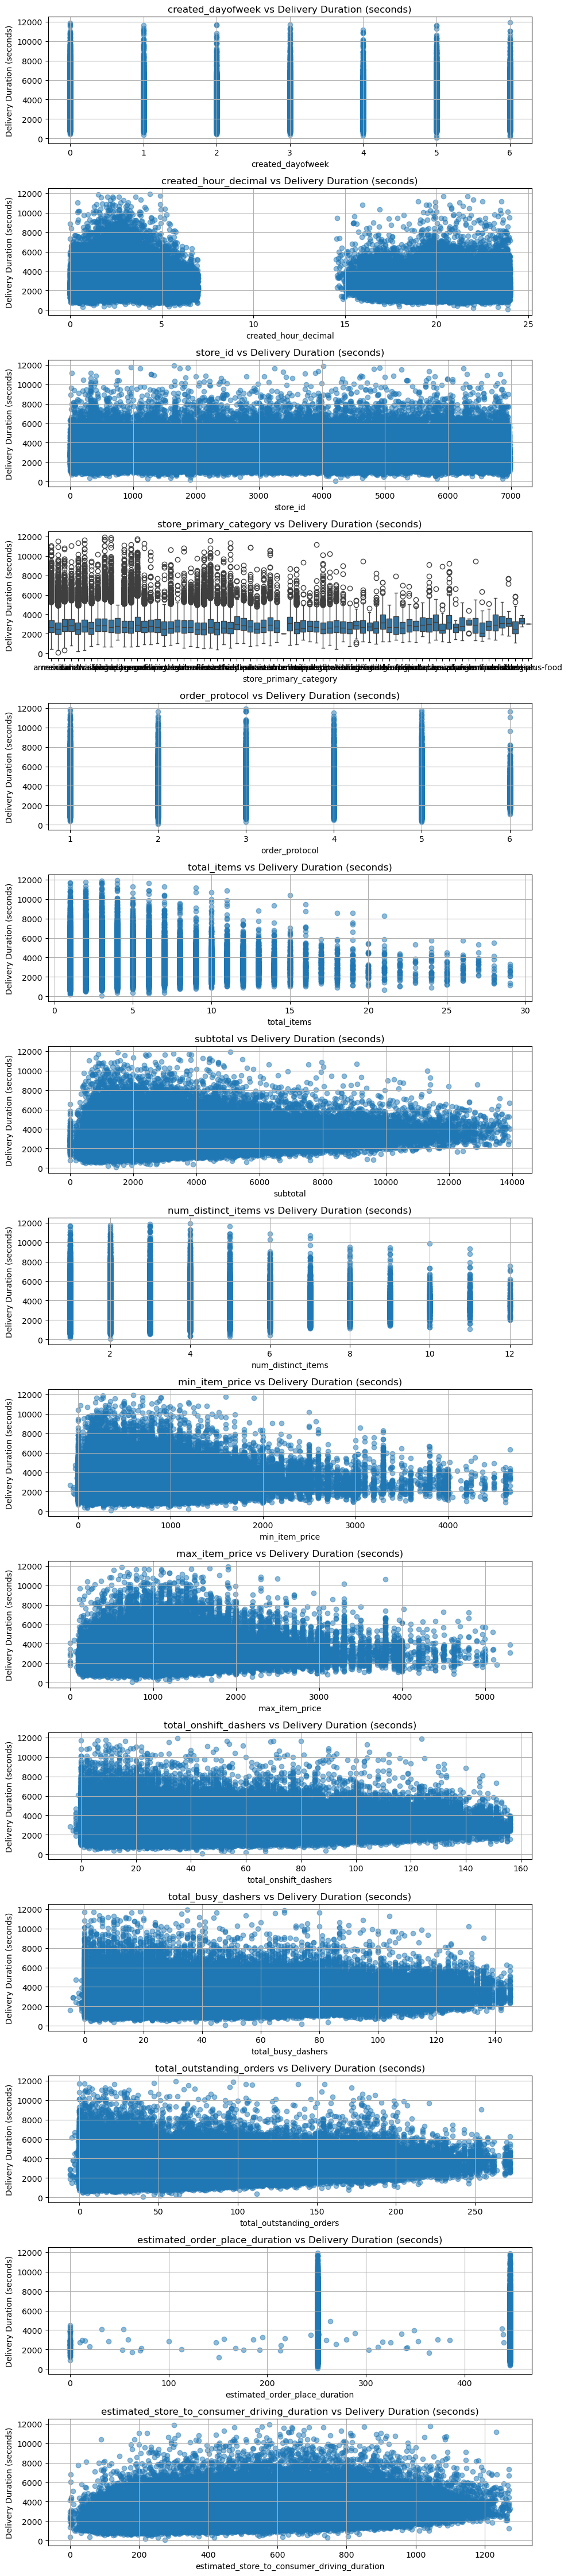

In [44]:


# Figure w/ subplots
fig, axes = plt.subplots(len(features), 1, figsize=(10, 3 * len(features)))

# Loop through each feature to plot
for i, feature in enumerate(features):
    ax = axes[i]  # get the axis for the current subplot
    
    if feature in ['created_at', 'actual_delivery_time']:  # Date columns
        df[feature] = pd.to_datetime(df[feature])
        ax.plot(df[feature], df['delivery_duration_seconds'], '.', alpha=0.3)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        ax.grid(True)
        
    elif feature == 'store_primary_category':  # Categorical columns
        sns.boxplot(x=df[feature], y=df['delivery_duration_seconds'], ax=ax)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        
    else:  # Numerical columns
        ax.scatter(df[feature], df['delivery_duration_seconds'], alpha=0.5)
        ax.set_title(f'{feature} vs Delivery Duration (seconds)')
        ax.set_xlabel(feature)
        ax.set_ylabel('Delivery Duration (seconds)')
        ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


This seems a lot more reasonable. 

# Making Data Trainable

Since there are 178,000 data samples, which would take too long to train, I decided to reduce the amount by setting a limited amount of stores.

In [48]:
# Looking at 25 stores with most frequent results
print(df['store_id'].value_counts().head(25))

store_id
6865    925
1311    843
314     808
1686    755
3937    717
6917    662
6074    628
4367    584
3748    552
1409    540
6503    539
6313    534
2056    533
1185    530
6281    526
6525    491
1853    489
4210    483
6151    469
4863    448
3620    446
1661    443
3813    418
2494    394
3019    388
Name: count, dtype: int64


In [49]:
# To see how many results there are
df['store_id'].value_counts().head(25).sum()

14145

I'm good with working with ~14,000 instances.

In [51]:
# Get top 25 most frequent store_ids as index
top_25 = df['store_id'].value_counts().head(25).index

# Filter the DataFrame
df = df[df['store_id'].isin(top_25)]


In [52]:
df

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,created_dayofweek,created_hour_decimal
1224,4.0,6313,dessert,5.0,6,4960,4,795,795,87.0,76.0,107.0,251,892.0,2892.0,2,2.316667
1225,4.0,6313,dessert,5.0,4,4930,4,1095,1250,66.0,63.0,90.0,251,567.0,3044.0,4,19.800000
1226,4.0,6313,dessert,5.0,2,1470,2,325,1095,50.0,50.0,55.0,251,150.0,2420.0,5,20.800000
1227,4.0,6313,dessert,5.0,1,1190,1,1095,1095,8.0,3.0,3.0,251,78.0,1283.0,6,16.216667
1228,4.0,6313,dessert,5.0,3,2410,3,225,1095,40.0,79.0,54.0,251,368.0,2958.0,5,19.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197187,4.0,1409,vietnamese,5.0,1,870,1,795,795,64.0,64.0,142.0,251,456.0,4091.0,0,2.733333
197188,4.0,1409,vietnamese,2.0,2,1015,2,195,795,67.0,53.0,58.0,251,396.0,1143.0,4,1.100000
197189,4.0,1409,vietnamese,5.0,1,870,1,795,795,33.0,13.0,13.0,251,280.0,1003.0,2,22.566667
197190,4.0,1409,vietnamese,5.0,1,1370,1,795,795,53.0,52.0,83.0,251,520.0,2529.0,0,4.166667


# Creating ML Models

In [54]:
# Arrange data into feature matrix and target vector
y = df.delivery_duration_seconds
X  = df.drop(columns = ['delivery_duration_seconds'])

In [55]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Creating Preprocessing pipeline
features = [
    'market_id', 'store_id', 'store_primary_category', 'order_protocol',
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration','created_dayofweek','created_hour_decimal'
]

# Split features into numerical and categorical
categorical_features = ['market_id', 'store_id', 'store_primary_category', 'order_protocol']
numerical_features = [col for col in features if col not in categorical_features]

# Preprocessing pipelines - no Imputer as we handled that previously
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])



In [57]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['total_items', 'subtotal',
                                  'num_distinct_items', 'min_item_price',
                                  'max_item_price', 'total_onshift_dashers',
                                  'total_busy_dashers',
                                  'total_outstanding_orders',
                                  'estimated_order_place_duration',
                                  'estimated_store_to_consumer_driving_duration',
                                  'created_dayofweek',
                                  'created_hour_decimal']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['market_id', 'store_id',
                                  'store_primary_category',
                                  'order_protocol'])])

## Instantiating Model

## Linear Regression

In [60]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',
                                                   'created_dayofweek',
                                                   'created_hour_decimal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market_id', 'store_id',
                                                   'store_primary_category',
                                                   'order_protocol'])])),
                ('model', LinearRegression())])

## Ridge Regression

In [62]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

ridge_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',
                                                   'created_dayofweek',
                                                   'created_hour_decimal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market_id', 'store_id',
                                                   'store_primary_category',
                                                   'order_protocol'])])),
                ('model', Ridge())])

## Lasso Regression

In [64]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter = 5000))
])

lasso_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',
                                                   'created_dayofweek',
                                                   'created_hour_decimal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market_id', 'store_id',
                                                   'store_primary_category',
                                                   'order_protocol'])])),
                ('model', Lasso(max_iter=5000))])

## Random Forests

In [66]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',
                                                   'created_dayofweek',
                                                   'created_hour_decimal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market_id', 'store_id',
                                                   'store_primary_category',
                                                   'order_protocol'])])),
                ('model', RandomForestRegressor(random_state=42))])

## Boosted Trees Regression

In [68]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

## SVM Regression

In [70]:
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR())
])

svr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'estimated_order_place_duration',
                                                   'estimated_store_to_consumer_driving_duration',
                                                   'created_dayofweek',
                                                   'created_hour_decimal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market_id', 'store_id',
                                                   'store_primary_category',
                                                   'order_protocol'])])),
                ('model', SVR())])

# Validation

In [72]:
# Evaluate using cross-validation
lr_cv_score = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='r2').mean()
print("Linear Regression CV R^2:", round(lr_cv_score, 4))


Linear Regression CV R^2: 0.4115


In [73]:
# Parameters chosen
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

# Set up GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')

# Fit to training data
ridge_grid.fit(X_train, y_train)

# Get best model and score
print("Best alpha:", ridge_grid.best_params_['model__alpha'])
print("Best score (R^2):", round(ridge_grid.best_score_,4))

Best alpha: 10
Best score (R^2): 0.4143


In [74]:
# Parameters chosen
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100,1000]
}

# Set up GridSearchCV
lasso_grid = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='r2')

# Fit to training data
lasso_grid.fit(X_train, y_train)

# Get best model and score
print("Best alpha:", lasso_grid.best_params_['model__alpha'])
print("Best score (R^2):", round(lasso_grid.best_score_,4))

Best alpha: 0.1
Best score (R^2): 0.4142


In [75]:
# Parameters chosen
rf_params = {
    'model__n_estimators': [17, 19, 21, 23, 25],
    'model__max_depth': [7, 9, 11, 13, 15]
}

# Set up GridSearchCV
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='r2')

# Fit to training data
rf_grid.fit(X_train, y_train)

# Get best model and score
print("Best Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest CV R^2:", round(rf_grid.best_score_, 4))


Best Random Forest Params: {'model__max_depth': 13, 'model__n_estimators': 25}
Best Random Forest CV R^2: 0.4212


In [76]:
# Parameters chosen
xgb_params = {
    'model__n_estimators': [17, 19, 21, 23, 25],
    'model__learning_rate': [0.15, 0.2, 0.25],
    'model__max_depth': [3, 5, 7, 9]
}

# Set up GridSearchCV
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='r2')

# Fit to training data
xgb_grid.fit(X_train, y_train)

# Get best model and score
print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost CV R^2:", round(xgb_grid.best_score_, 4))


Best XGBoost Params: {'model__learning_rate': 0.15, 'model__max_depth': 7, 'model__n_estimators': 25}
Best XGBoost CV R^2: 0.4428


In [77]:
# Parameters chosen
svr_params = {
    'model__C': [10, 100, 1000],
    'model__kernel': ['rbf', 'linear'],
    'model__gamma': ['scale', 'auto', 0.01, 0.001]
}

# Set up GridSearchCV
svr_grid = GridSearchCV(svr_pipeline, svr_params, cv=5, scoring='r2', n_jobs=-1)

# Fit to training data
svr_grid.fit(X_train, y_train)

# Get best model and score
print("Best SVR Params:", svr_grid.best_params_)
print("Best SVR CV R^2:", round(svr_grid.best_score_, 4))

Best SVR Params: {'model__C': 1000, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best SVR CV R^2: 0.4236


In [78]:
models = {
    'Linear Regression': {
        'estimator': lr_pipeline,
        'score': lr_cv_score,
        'params': 'N/A (no hyperparameters)'
    },
    'Ridge Regression': {
        'estimator': ridge_grid.best_estimator_,
        'score': ridge_grid.best_score_,
        'params': ridge_grid.best_params_
    },
    'Lasso Regression': {
        'estimator': lasso_grid.best_estimator_,
        'score': lasso_grid.best_score_,
        'params': lasso_grid.best_params_
    },
    'Random Forest': {
        'estimator': rf_grid.best_estimator_,
        'score': rf_grid.best_score_,
        'params': rf_grid.best_params_
    },
    'XGBoost': {
        'estimator': xgb_grid.best_estimator_,
        'score': xgb_grid.best_score_,
        'params': xgb_grid.best_params_
    },
    'SVM': {
        'estimator': svr_grid.best_estimator_,
        'score': svr_grid.best_score_,
        'params': svr_grid.best_params_
    }
}

# Find best model by R^2 score
best_model_name, best_model_info = max(models.items(), key=lambda x: x[1]['score'])

# Output best model and its hyperparameters
print(f"Best Model: {best_model_name}")
print(f"R^2 Score: {round(best_model_info['score'], 4)}")
print(f"Best Parameters: {best_model_info['params']}")


Best Model: XGBoost
R^2 Score: 0.4428
Best Parameters: {'model__learning_rate': 0.15, 'model__max_depth': 7, 'model__n_estimators': 25}


# Results

We will evaluate the best performing model's results

In [81]:
# Get the best trained model
best_model = best_model_info['estimator']

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# r2 value in tests

r2 = round(r2_score(y_test, y_pred),4)
print("Test R2:", r2)

Test R2: 0.4582


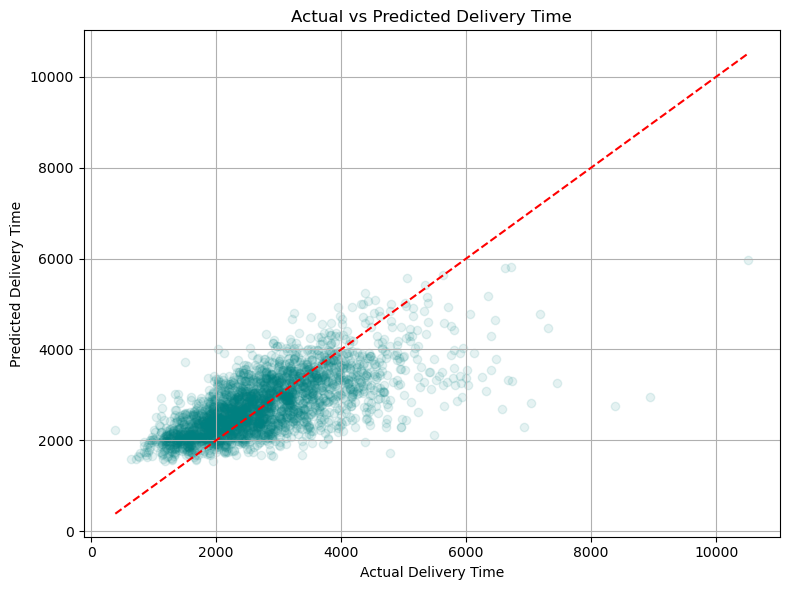

In [82]:
# Graph that plots Actual vs Predicted delivery time
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.grid(True)
plt.tight_layout()
plt.show()